<a href="https://colab.research.google.com/github/matfonbi/Reseau-de-neurones-Malaria/blob/main/TP_Reseau_Neurone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import zipfile
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
zip_path = '/content/drive/My Drive/Colab_Notebooks/TP_reseau_neurone/malaria_hematie_dataset.zip'

In [3]:
extract_path = '/content/dataset'

Extraire le dataset

In [4]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Dataset extrait avec succès !")

Dataset extrait avec succès !


In [5]:
import os
import shutil
import random

In [6]:
original_dataset_path = '/content/dataset/malaria_hematie_dataset'
output_path = '/content/splitted_dataset'

In [7]:
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

In [8]:
for split in ['train', 'val', 'test']:
    for category in ['parasitized', 'uninfected']:
        os.makedirs(os.path.join(output_path, split, category), exist_ok=True)

In [9]:
def split_data(original_path, output_path, train_ratio, val_ratio, test_ratio):
    for category in os.listdir(original_path):  # Parcourir les catégories (parasitized/uninfected)
        category_path = os.path.join(original_path, category)

        if os.path.isdir(category_path):  # Vérifie que c'est un dossier
            # Récupérer la liste des fichiers
            images = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]
            random.shuffle(images)  # Mélanger les fichiers aléatoirement

            # Calculer les indices pour la division
            train_count = int(len(images) * train_ratio)
            val_count = int(len(images) * val_ratio)

            # Diviser les images
            train_images = images[:train_count]
            val_images = images[train_count:train_count + val_count]
            test_images = images[train_count + val_count:]

            # Copier les fichiers dans les sous-dossiers appropriés
            for image in train_images:
                shutil.copy(os.path.join(category_path, image), os.path.join(output_path, 'train', category, image))
            for image in val_images:
                shutil.copy(os.path.join(category_path, image), os.path.join(output_path, 'val', category, image))
            for image in test_images:
                shutil.copy(os.path.join(category_path, image), os.path.join(output_path, 'test', category, image))

In [10]:
split_data(original_dataset_path, output_path, train_ratio, val_ratio, test_ratio)
print("Les données ont été divisées et enregistrées dans le dossier :", output_path)

Les données ont été divisées et enregistrées dans le dossier : /content/splitted_dataset


In [11]:
# Vérifier le nombre de fichiers dans chaque sous-dossier
for split in ['train', 'val', 'test']:
    for category in ['parasitized', 'uninfected']:
        path = os.path.join(output_path, split, category)
        print(f"{split}/{category} : {len(os.listdir(path))} images")


train/parasitized : 9645 images
train/uninfected : 9645 images
val/parasitized : 2066 images
val/uninfected : 2066 images
test/parasitized : 2068 images
test/uninfected : 2068 images


In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
train_dir = '/content/splitted_dataset/train'
val_dir = '/content/splitted_dataset/val'
test_dir = '/content/splitted_dataset/test'

In [14]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

Normalisation

In [15]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   brightness_range=[0.8, 1.2],
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

Found 19290 images belonging to 2 classes.


In [17]:
val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 4132 images belonging to 2 classes.


In [18]:
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 4136 images belonging to 2 classes.


Verification du resultat

In [19]:
# Obtenir un batch d'images et leurs labels
images, labels = next(train_data)

# Vérifier les valeurs minimum et maximum
print(f"Valeur minimale : {images[0].min()}, Valeur maximale : {images[0].max()}")



Valeur minimale : 0.0, Valeur maximale : 1.0


In [20]:
from tensorflow.keras import Sequential, layers

In [21]:
mon_premier_cnn = Sequential([
    # Couche d'entrée
    layers.Input(shape=(128, 128, 3)),  # Images 128x128 en RGB (3 canaux)

    # Première couche convolutive + pooling
    layers.Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),

    # Deuxième couche convolutive + pooling
    layers.Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),

    # Couche Flatten
    layers.Flatten(),

    # Couche fully connected
    layers.Dense(128, activation='relu'),

    layers.Dropout(0.2),
    # Couche de sortie (binaire)
    layers.Dense(1, activation='sigmoid')  # Pour une classification binaire
])


In [22]:
mon_premier_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,897,025 (56.83 MB)

 Trainable params: 14,897,025 (56.83 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
import numpy as np
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow import keras

In [24]:
def scheduler(epoch, lr):
    if epoch < 3:  # Pendant les 5 premières époques, garder le taux d'apprentissage initial
        return lr
    else:  # Ensuite, diminuer le taux d'apprentissage
        return lr * np.exp(-0.1)

lr_decay = LearningRateScheduler(scheduler)

In [25]:
early_stopping = EarlyStopping(
    monitor="val_loss",  # Surveiller la perte de validation
    patience=5,  # Arrêter après 5 époques sans amélioration
    restore_best_weights=True  # Restaurer les poids du meilleur modèle
)

In [26]:
mon_premier_cnn.compile(
    loss="binary_crossentropy",  # Pour la classification binaire
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # Optimiseur Adam
    metrics=["accuracy"]
)

In [ ]:
history_cnn = mon_premier_cnn.fit(
    train_data,  # Données d'entraînement
    validation_data=val_data,  # Données de validation
    epochs=100,  # Nombre maximum d'époques
    callbacks=[lr_decay, early_stopping]  # Ajouter les callbacks ici
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 148s 233ms/step - accuracy: 0.6242 - loss: 0.6515 - val_accuracy: 0.7885 - val_loss: 0.5418 - learning_rate: 1.0000e-04
Epoch 2/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 139s 231ms/step - accuracy: 0.7900 - loss: 0.5003 - val_accuracy: 0.9112 - val_loss: 0.3007 - learning_rate: 1.0000e-04
Epoch 3/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 136s 225ms/step - accuracy: 0.8723 - loss: 0.3466 - val_accuracy: 0.9095 - val_loss: 0.2306 - learning_rate: 1.0000e-04
Epoch 4/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 136s 226ms/step - accuracy: 0.8838 - loss: 0.3084 - val_accuracy: 0.9197 - val_loss: 0.2031 - learning_rate: 9.0484e-05
Epoch 5/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 137s 227ms/step - accuracy: 0.8921 - loss: 0.2906 - val_accuracy: 0.9250 - val_loss: 0.1988 - learning_rate: 8.1873e-05
Epoch 6/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 145s 241ms/step - accuracy: 0.8981 - loss: 0.2835 - val_accuracy: 0.9301 - val_loss: 0.1840 - learning_rate: 7.4082e-05
Epoch 7/100
603/603 ━━━━━━━━━━━━━━

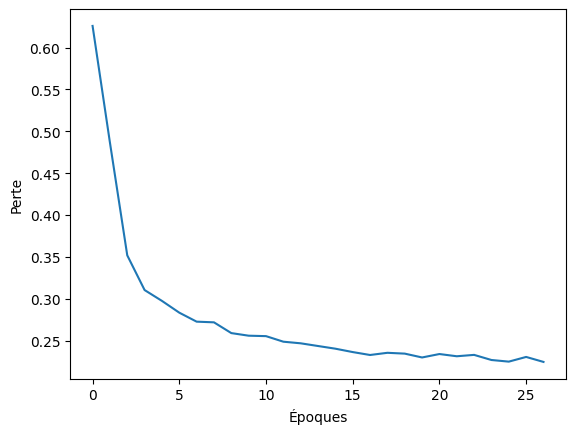

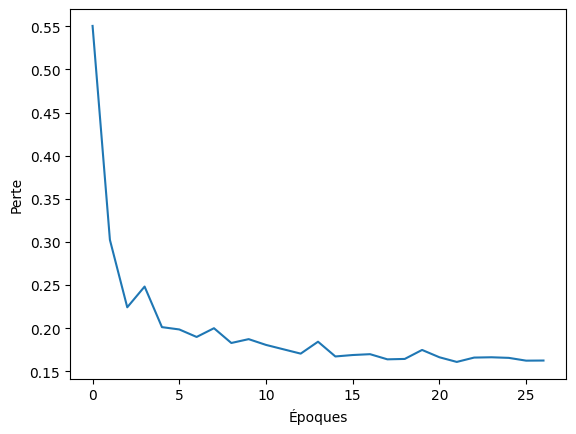

In [28]:
import matplotlib.pyplot as plt

plt.plot(history_cnn.history['loss'], label='Perte entraînement')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.show()

plt.plot(history_cnn.history['val_loss'], label='Perte validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.show()

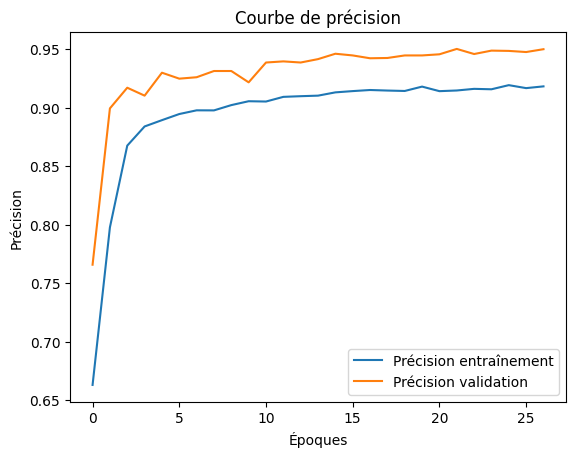

In [29]:
# Courbe de précision
plt.plot(history_cnn.history['accuracy'], label='Précision entraînement')
plt.plot(history_cnn.history['val_accuracy'], label='Précision validation')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.title('Courbe de précision')
plt.legend()
plt.show()


In [30]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input_vgg

In [31]:
# Charger le modèle VGG16 pré-entraîné sur ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Congeler les couches du modèle pré-entraîné
base_model.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [32]:
# Ajouter les couches personnalisées pour ton problème
vgg16_model = models.Sequential([
    base_model,  # Modèle pré-entraîné comme base
    layers.Flatten(),  # Aplatir les sorties du modèle
    layers.Dense(1000, activation='relu'),
    layers.Dense(128, activation='relu'),  # Couche fully connected
    layers.Dropout(0.3),  # Dropout pour éviter le surapprentissage
    layers.Dense(1, activation='sigmoid')  # Couche de sortie pour classification binaire
])

In [33]:
# Compiler le modèle
vgg16_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',  # Fonction de perte pour classification binaire
    metrics=['accuracy']  # Suivre la précision
)

In [34]:
train_datagen_vgg = ImageDataGenerator(preprocessing_function=preprocess_input_vgg,
                                       rotation_range=30,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       brightness_range=[0.8, 1.2],
                                       fill_mode='nearest')
val_datagen_vgg = ImageDataGenerator(preprocessing_function=preprocess_input_vgg)

In [35]:
train_data_vgg = train_datagen_vgg.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

val_data_vgg = val_datagen_vgg.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)


Found 19290 images belonging to 2 classes.
Found 4132 images belonging to 2 classes.


In [ ]:
# Entraîner le modèle
history_vgg = vgg16_model.fit(
    train_data_vgg,
    validation_data=val_data_vgg,
    epochs=30,  # Peut être augmenté si nécessaire
    validation_steps=val_data.samples // val_data.batch_size,
    callbacks=[lr_decay, early_stopping]
)

Epoch 1/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 137s 214ms/step - accuracy: 0.8073 - loss: 1.1746 - val_accuracy: 0.9210 - val_loss: 0.1986 - learning_rate: 1.0000e-04
Epoch 2/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 141s 223ms/step - accuracy: 0.9008 - loss: 0.2609 - val_accuracy: 0.9251 - val_loss: 0.1915 - learning_rate: 1.0000e-04
Epoch 3/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 122s 203ms/step - accuracy: 0.9172 - loss: 0.2305 - val_accuracy: 0.9106 - val_loss: 0.2182 - learning_rate: 1.0000e-04
Epoch 4/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 122s 202ms/step - accuracy: 0.9229 - loss: 0.2129 - val_accuracy: 0.9239 - val_loss: 0.1834 - learning_rate: 9.0484e-05
Epoch 5/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 123s 203ms/step - accuracy: 0.9267 - loss: 0.2086 - val_accuracy: 0.9285 - val_loss: 0.1929 - learning_rate: 8.1873e-05
Epoch 6/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 142s 236ms/step - accuracy: 0.9243 - loss: 0.2053 - val_accuracy: 0.9218 - val_loss: 0.1906 - learning_rate: 7.4082e-05
Epoch 7/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
vgg16_model.summary()

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_res

In [ ]:
# Charger ResNet50 pré-entraîné
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Geler les couches pré-entraînées
base_model.trainable = False

In [ ]:
resnet50_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Remplace Flatten pour mieux gérer la spatialité des features
    layers.Dense(1000, activation='relu'),
    layers.Dense(128, activation='relu'),  # Couche fully connected
    layers.Dropout(0.3),  # Dropout pour éviter l'overfitting
    layers.Dense(1, activation='sigmoid')  # Couche de sortie pour classification binaire
])

In [ ]:
resnet50_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
train_datagen_res = ImageDataGenerator(preprocessing_function=preprocess_input_res,
                                       rotation_range=30,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       brightness_range=[0.8, 1.2],
                                       fill_mode='nearest')
val_datagen_res = ImageDataGenerator(preprocessing_function=preprocess_input_res)

train_data_res = train_datagen_res.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

val_data_res = val_datagen_res.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

In [ ]:
history_res = resnet50_model.fit(
    train_data_res,
    validation_data=val_data_res,
    epochs=30,
    validation_steps=val_data_res.samples // val_data_res.batch_size,
    callbacks=[lr_decay, early_stopping]
)

In [ ]:
# Sauvegarder les poids des modèles entraînés
mon_premier_cnn.save_weights("model_from_scratch.weights.h5")
vgg16_model.save_weights("model_vgg16.weights.h5")
resnet50_model.save_weights("model_resnet50.weights.h5")

In [ ]:
mon_premier_cnn.load_weights("model_from_scratch.weights.h5")
vgg16_model.load_weights("model_vgg16.weights.h5")
resnet50_model.load_weights("model_resnet50.weights.h5")

In [ ]:
import numpy as np

# Initialiser les listes pour stocker les vrais labels et les prédictions
y_true = []
y_pred_scratch = []
y_pred_vgg16 = []
y_pred_resnet50 = []

# Parcourir le dataset de test batch par batch
for batch_images, batch_labels in test_data:
    y_true.extend(batch_labels)  # Ajouter les vrais labels

    # Générer les prédictions pour chaque modèle
    y_pred_scratch.extend(mon_premier_cnn.predict(batch_images).ravel())
    y_pred_vgg16.extend(vgg16_model.predict(batch_images).ravel())
    y_pred_resnet50.extend(resnet50_model.predict(batch_images).ravel())

    # Arrêter la boucle après avoir traité toutes les images
    if len(y_true) >= test_data.samples:
        break

# Convertir les listes en tableaux numpy
y_true = np.array(y_true)
y_pred_scratch = np.array(y_pred_scratch)
y_pred_vgg16 = np.array(y_pred_vgg16)
y_pred_resnet50 = np.array(y_pred_resnet50)

# Vérifier que les valeurs sont correctes
print(f"Vérification des valeurs min/max des prédictions Scratch : {y_pred_scratch.min()} - {y_pred_scratch.max()}")
print(f"Vérification des valeurs min/max des prédictions VGG16 : {y_pred_vgg16.min()} - {y_pred_vgg16.max()}")
print(f"Vérification des valeurs min/max des prédictions ResNet50 : {y_pred_resnet50.min()} - {y_pred_resnet50.max()}")
print(f"Vérification des labels : {np.unique(y_true)}")  # Doit être [0, 1]



In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calcul des courbes ROC
fpr_scratch, tpr_scratch, _ = roc_curve(y_true, y_pred_scratch)
fpr_vgg16, tpr_vgg16, _ = roc_curve(y_true, y_pred_vgg16)
fpr_resnet50, tpr_resnet50, _ = roc_curve(y_true, y_pred_resnet50)

# Calcul des AUC
auc_scratch = auc(fpr_scratch, tpr_scratch)
auc_vgg16 = auc(fpr_vgg16, tpr_vgg16)
auc_resnet50 = auc(fpr_resnet50, tpr_resnet50)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_scratch, tpr_scratch, label=f"From Scratch (AUC = {auc_scratch:.2f})", linestyle='--')
plt.plot(fpr_vgg16, tpr_vgg16, label=f"VGG16 (AUC = {auc_vgg16:.2f})", linestyle='-.')
plt.plot(fpr_resnet50, tpr_resnet50, label=f"ResNet50 (AUC = {auc_resnet50:.2f})", linestyle='-')

# Ajouter labels et légende
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbes ROC des modèles")
plt.legend()
plt.grid()
plt.show()

# Affichage des valeurs AUC
print(f"AUC From Scratch: {auc_scratch:.2f}")
print(f"AUC VGG16: {auc_vgg16:.2f}")
print(f"AUC ResNet50: {auc_resnet50:.2f}")

In [ ]:
from sklearn.metrics import confusion_matrix

# Convertir les prédictions en classes binaires (0 ou 1) avec un seuil de 0.5
y_pred_scratch_bin = (y_pred_scratch >= 0.5).astype(int)
y_pred_vgg16_bin = (y_pred_vgg16 >= 0.5).astype(int)
y_pred_resnet50_bin = (y_pred_resnet50 >= 0.5).astype(int)

# Calcul des matrices de confusion
cm_scratch = confusion_matrix(y_true, y_pred_scratch_bin)
cm_vgg16 = confusion_matrix(y_true, y_pred_vgg16_bin)
cm_resnet50 = confusion_matrix(y_true, y_pred_resnet50_bin)

# Affichage des matrices de confusion
print("Matrice de Confusion - Scratch Model :\n", cm_scratch)
print("Matrice de Confusion - VGG16 :\n", cm_vgg16)
print("Matrice de Confusion - ResNet50 :\n", cm_resnet50)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculer_metrics(y_true, y_pred_bin, model_name):
    accuracy = accuracy_score(y_true, y_pred_bin)
    precision = precision_score(y_true, y_pred_bin)
    recall = recall_score(y_true, y_pred_bin)
    f1 = f1_score(y_true, y_pred_bin)

    # Calcul de la sensibilité et spécificité
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_bin).ravel()
    sensibilite = tp / (tp + fn)  # Sensibilité = Recall
    specificite = tn / (tn + fp)  # Spécificité

    # Affichage des métriques
    print(f"📊 {model_name} :")
    print(f"   Accuracy : {accuracy:.4f}")
    print(f"   Precision : {precision:.4f}")
    print(f"   Recall / Sensibilité : {recall:.4f}")
    print(f"   F1-Score : {f1:.4f}")
    print(f"   Spécificité : {specificite:.4f}\n")

# Calcul des métriques pour chaque modèle
calculer_metrics(y_true, y_pred_scratch_bin, "From Scratch")
calculer_metrics(y_true, y_pred_vgg16_bin, "VGG16")
calculer_metrics(y_true, y_pred_resnet50_bin, "ResNet50")